# CityScape Image Segmentation with U-Net

Welcome! We are building a U-Net, a type of CNN designed for quick, precise image segmentation, and using it to predict a label for every single pixel in an image - in this case, an image from a self-driving car dataset. 

This type of image classification is called semantic image segmentation.The word “semantic” here refers to what's being shown, so for example the “Car” class is indicated below by the dark blue mask, and "Person" is indicated with a red mask:

<center><img src="images/carseg.png" style="width:500px;height:250;"></center>
<caption><center> <u><b>Figure 1</u></b>: Example of a segmented image <br> </center></caption>

As you might imagine, region-specific labeling is a pretty crucial consideration for self-driving cars, which require a pixel-perfect understanding of their environment so they can change lanes and avoid other cars, or any number of traffic obstacles that can put peoples' lives in danger. 

Onward, to this grand and glorious quest! 

## Table of Content

- [1 - Packages](#1)
- [2 - Load and Split the Data](#2)
    - [2.1 - Spliting our Dataset into Unmasked and Masked Images](#2-1)
    - [2.2 - Preprocessing our Data](#2-2)
- [3 - U-Net](#3)
    - [3.1 - Model Details](#3-1)
    - [3.2 - Encoder (Downsampling Block)](#3-2)
    - [3.3 - Decoder (Upsampling Block)](#3-3)
    - [3.4 - Build the Model](#3-4)
    - [3.5 - Set Model Dimensions](#3-5)
    - [3.6 - Loss Function](#3-6)
    - [3.7 - Dataset Handling](#3-7)
- [4 - Train the Model](#4)
    - [4.1 - Create Predicted Masks](#4-1)
    - [4.2 - Plot Model Accuracy](#4-2)
    - [4.3 - Show Predictions](#4-3)

<a name='1'></a>
## 1 - Packages

Run the cell below to import all the libraries we need:

In [1]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

import seaborn as sns

<a name='2'></a>
## 2 - Load and Split the Data

In [2]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import imageio

import matplotlib.pyplot as plt
%matplotlib inline

path = ''
image_path = os.path.join(path, './data/CameraRGB/')
mask_path = os.path.join(path, './data/CameraMask/')
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]

### Check out the some of the unmasked and masked images from the dataset:

Text(0.5, 1.0, 'Segmentation')

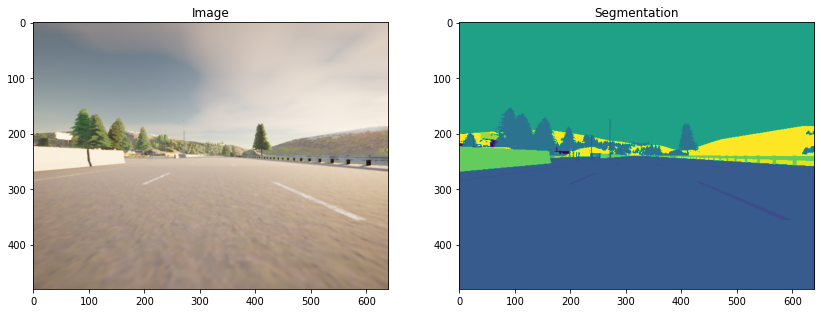

In [3]:
N = 2
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])
#mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')

<a name='2-1'></a>
### 2.1 - Spliting our Dataset into Unmasked and Masked Images

In [4]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'.\\data\\CameraRGB\\000026.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'.\\data\\CameraMask\\000026.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'.\\data\\CameraRGB\\000027.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'.\\data\\CameraMask\\000027.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'.\\data\\CameraRGB\\000028.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'.\\data\\CameraMask\\000028.png'>)


In [5]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'./data/CameraRGB/000026.png', shape=(), dtype=string)
tf.Tensor(b'./data/CameraMask/000026.png', shape=(), dtype=string)


<a name='2-2'></a>
### 2.2 - Preprocessing our Data

In [6]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')

    input_image = input_image / 255.

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

<a name='3'></a>
## 3 - U-Net 

U-Net, named for its U-shape, was originally created in 2015 for tumor detection, but in the years since has become a very popular choice for other semantic segmentation tasks. 

U-Net builds on a previous architecture called the Fully Convolutional Network, or FCN, which replaces the dense layers found in a typical CNN with a transposed convolution layer that upsamples the feature map back to the size of the original input image, while preserving the spatial information. 

Unfortunately, the final feature layer of the FCN suffers from information loss due to downsampling too much. It then becomes difficult to upsample after so much information has been lost, causing an output that looks rough. 

U-Net improves on the FCN, using a somewhat similar design, but differing in some important ways.  Instead of one transposed convolution at the end of the network, it uses a matching number of convolutions for downsampling the input image to a feature map, and transposed convolutions for upsampling those maps back up to the original input image size. It also adds skip connections, to retain information that would otherwise become lost during encoding. 

<a name='3-1'></a>
### 3.1 - Model Details

<center><img src="images/unet.png" style="width:700px;height:400;"></center>
<caption><center> <u><b> Figure 2 </u></b>: U-Net Architecture<br> </center></caption>

**Contracting path** (Encoder containing downsampling steps):
Images are first fed through several convolutional layers which reduce height and width, while growing the number of channels.

**Crop function**: This step crops the image from the contracting path and concatenates it to the current image on the expanding path to create a skip connection. 

**Expanding path** (Decoder containing upsampling steps):
The expanding path performs the opposite operation of the contracting path, growing the image back to its original size, while shrinking the channels gradually.
Next is a concatenation with the correspondingly cropped feature map from the contracting path

**Final Feature Mapping Block**: In the final layer, a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes. 

The U-Net network has 23 convolutional layers in total. 

<a name='3-2'></a>
### 3.2 - Encoder (Downsampling Block) 

<center><img src="images/encoder.png" style="width:500px;height:500;"></center>
<caption><center> <u><b>Figure 3</u></b>: The U-Net Encoder up close <br> </center></caption>

The encoder is a stack of various conv_blocks:

Each `conv_block()` is composed of 2 **Conv2D** layers  with ReLU activations. We will apply **Dropout**, and **MaxPooling2D** to some conv_blocks.
The function will  return two tensors: 
- `next_layer`: That will go into the next block. 
- `skip_connection`: That will go into the corresponding decoding block.

**Note**: If `max_pooling=True`, the `next_layer` will be the output of the MaxPooling2D layer, but the `skip_connection` will be the output of the previously applied layer(Conv2D or Dropout, depending on the case). Else, both results will be identical.  

In [7]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    ### START CODE HERE
    conv = Conv2D(filters=n_filters, # Number of filters
                  kernel_size=3, # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(filters=n_filters, # Number of filters
                  kernel_size=3, # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    ### END CODE HERE
    
    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
        
    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2,2))(conv)
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

<a name='3-3'></a>
### 3.3 - Decoder (Upsampling Block)

The decoder, or upsampling block, upsamples the features back to the original image size. At each upsampling level, we'll take the output of the corresponding encoder block and concatenate it before feeding to the next decoder block.

<center><img src="images/decoder.png" style="width:500px;height:500;"></center>
<caption><center> <u><b>Figure 4</u></b>: The U-Net Decoder up close <br> </center></caption> 

Here we'll encounter the `Conv2DTranspose` layer, which performs the inverse of the `Conv2D` layer.

Each `upsampling_block`: 
* Takes the arguments `expansive_input` (which is the input tensor from the previous layer) and `contractive_input` (the input tensor from the previous skip layer)
* The number of filters here is the same as in the downsampling block
* Our `Conv2DTranspose` layer will take `n_filters` with shape (3,3) and a stride of (2,2), with padding set to `same`. It's applied to `expansive_input`, or the input tensor from the previous layer. 

In this block we will also concatenate the outputs from the encoder blocks, creating skip connections. 

In [8]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    
    up = Conv2DTranspose(filters=n_filters, # Number of filters
                         kernel_size=3, # Kernel size   
                         strides=(2,2),
                         padding='same')(expansive_input)
    
    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(filters=n_filters, # Number of filters
                  kernel_size=3, # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(merge)
    conv = Conv2D(filters=n_filters, # Number of filters
                  kernel_size=3, # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    
    return conv

<a name='3-4'></a>
### 3.4 - Building the Model

This is where we will put it all together, by chaining the encoder, bottleneck, and decoder! 

For the function `unet_model`, specify the input shape, number of filters, and number of classes (23 in this case). 

In [9]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    # Contracting Path (encoding)
    cblock1 = conv_block(inputs, n_filters)
    
    cblock2 = conv_block(cblock1[0], n_filters*2)
    cblock3 = conv_block(cblock2[0], n_filters*4)
    cblock4 = conv_block(cblock3[0], n_filters*8, dropout_prob=0.3) # Include a dropout of 0.3 for this layer
    # Include a dropout of 0.3 for this layer, and avoid the max_pooling layer
    cblock5 = conv_block(cblock4[0], n_filters*16, dropout_prob=0.3,max_pooling=False) 

    # Expanding Path (decoding)
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  n_filters*8)
    ublock7 = upsampling_block(ublock6, cblock3[1], n_filters*4 )
    ublock8 = upsampling_block(ublock7, cblock2[1], n_filters*2)
    ublock9 = upsampling_block(ublock8, cblock1[1], n_filters)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    conv10 = Conv2D(n_classes, kernel_size=1, padding='same')(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

<a name='3-5'></a>
### 3.5 - Set Model Dimensions

In [10]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

### Check out the model summary below! 

In [11]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 128, 3)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 96, 128, 32)  896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 96, 128, 32)  9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 48, 64, 32)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

<a name='3-6'></a>
### 3.6 - Loss Function

In semantic segmentation, we need as many masks as we have object classes. In the dataset we are using, each pixel in every mask has been assigned a single integer probability that it belongs to a certain class, from 0 to num_classes-1. The correct class is the layer with the higher probability. 

Here, we'll use sparse categorical crossentropy as our loss function, to perform pixel-wise multiclass prediction. 

In [12]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

<a name='3-7'></a>
### 3.7 - Dataset Handling

Below, define a function that allows us to display both an input image, and its ground truth: the true mask. The true mask is what our trained model output is aiming to get as close to as possible. 

In [13]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(480, 640, 1)


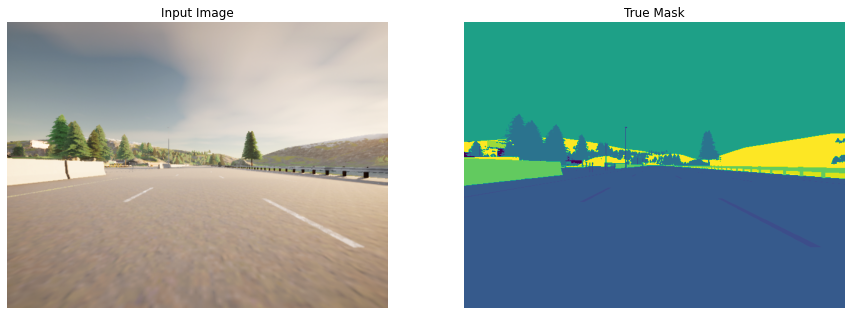

In [14]:
for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

(96, 128, 1)


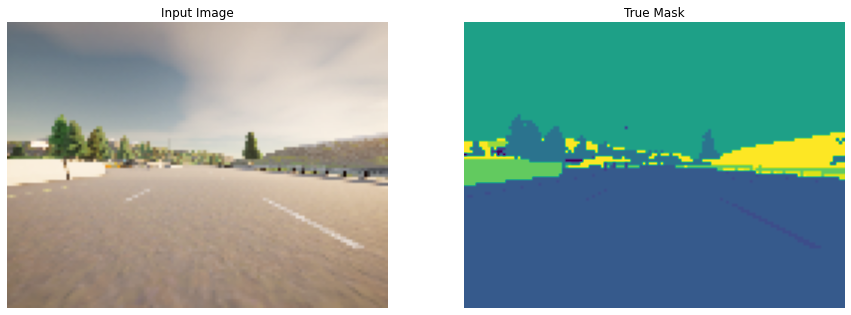

In [15]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

<a name='4'></a>
## 4 - Train the Model

In [16]:
EPOCHS = 18
VAL_SUBSPLITS = 4
BUFFER_SIZE = 250
BATCH_SIZE = 20
processed_image_ds.batch(BATCH_SIZE)
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/18
53/53 [==============================] - 78s 1s/step - loss: 2.6193 - accuracy: 0.3807
Epoch 2/18
53/53 [==============================] - 29s 550ms/step - loss: 1.0674 - accuracy: 0.7607
Epoch 3/18
53/53 [==============================] - 29s 555ms/step - loss: 0.7497 - accuracy: 0.7979
Epoch 4/18
53/53 [==============================] - 30s 565ms/step - loss: 0.6508 - accuracy: 0.8125
Epoch 5/18
53/53 [==============================] - 30s 567ms/step - loss: 0.6109 - accuracy: 0.8152
Epoch 6/18
53/53 [==============================] - 30s 570ms/step - loss: 0.5815 - accuracy: 0.8128
Epoch 7/18
53/53 [==============================] - 30s 571ms/step - loss: 0.5488 - accuracy: 0.8244
Epoch 8/18
53/53 [==============================] - 30s 573ms/step - loss: 0.5411 - accuracy: 0.8306
Epoch 9/18
53/53 [==============================] - 30s 573ms/step - loss:

<a name='4-1'></a>
### 4.1 - Create Predicted Masks 

In [17]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

<a name='4-2'></a>
### 4.2 - Plot Model Accuracy

Let's see how our model performed!

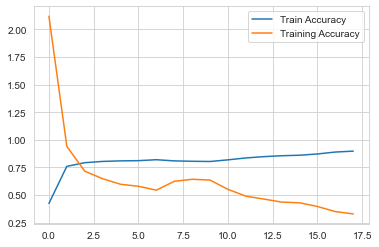

In [21]:
sns.set_style('whitegrid')
plt.plot(model_history.history["accuracy"])
plt.plot(model_history.history["loss"])
plt.legend(labels= ['Train Accuracy' , 'Training Accuracy'])
plt.legend
plt.show()

<a name='4-3'></a>
### 4.3 - Show Predictions 

Next, checking the predicted masks against the true mask and the original input image:

In [19]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

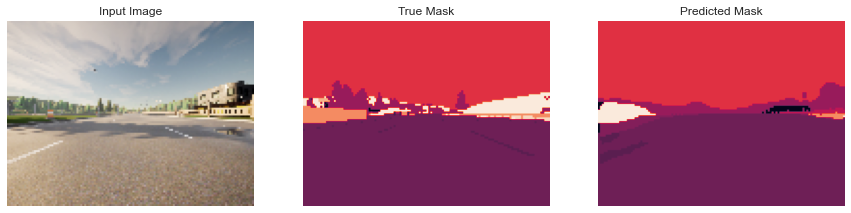

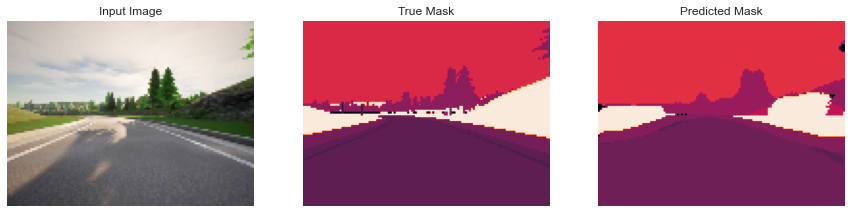

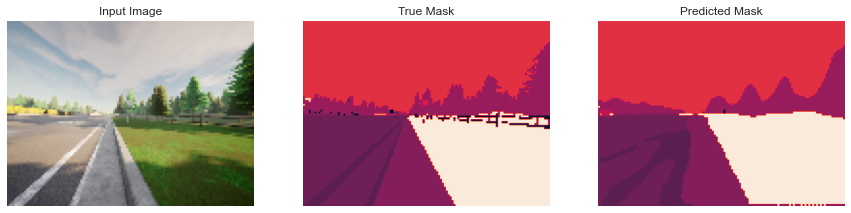

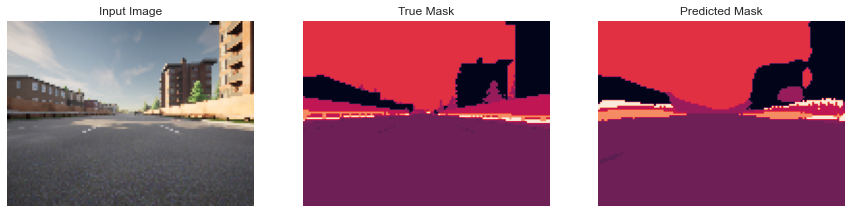

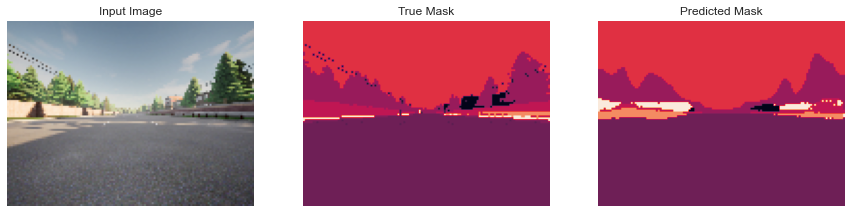

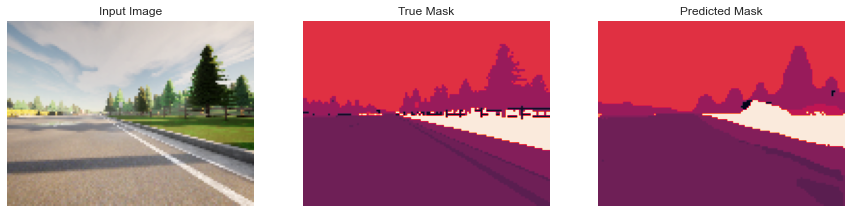

In [20]:
show_predictions(train_dataset, 6)